<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp?1" width="100px"></a>
</td>
</tr>
</table>

# Chapter 7: Finetuning To Follow Instructions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !mkdir /content/drive/MyDrive/Research/
%cd /content/drive/MyDrive/Research/GPT2-Fine-Tuning

/content/drive/MyDrive/Research/GPT2-Fine-Tuning


In [ ]:
!ls

ch07.ipynb  gpt_model_code.py  NepaliBPE	     __pycache__
data.json   gpt_model.py       previous_chapters.py


In [ ]:
!pip install tiktoken --quiet

In [ ]:
from importlib.metadata import version


pkgs = [
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
tiktoken version: 0.9.0
torch version: 2.6.0+cu124
tqdm version: 4.67.1
tensorflow version: 2.18.0


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/overview.webp?1" width=500px>

## 7.1 Introduction to instruction finetuning

- In chapter 5, we saw that pretraining an LLM involves a training procedure where it learns to generate one word at a time
- Hence, a pretrained LLM is good at text completion, but it is not good at following instructions
- In this chapter, we teach the LLM to follow instructions better

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/instruction-following.webp" width=500px>

- The topics covered in this chapter are summarized in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-1.webp?1" width=500px>

## 7.2 Preparing a dataset for supervised instruction finetuning

- We will work with an instruction dataset I prepared for this chapter

In [ ]:
# Probably should `clean_data(new_crawled_data)` before merging `new_crawled_data.csv` and previous`cleaned_data.csv`

from bs4 import BeautifulSoup
import csv
import json
import re
import string
import pandas as pd


class CleanData:
    def __init__(self):
        pass
        # return text
    # Example of removing HTML tags
    def clean_html(self, text):
        '''
        # HTML Tag Removal:
        * removes html tags like: <h1>
        * Removes css or js code inside <style> and <script> tags
        '''
        soup = BeautifulSoup(text, "lxml")

        # Remove all <script> and <style> tags
        for script_or_style in soup(['script', 'style']):
            script_or_style.decompose()

        # Get text from the modified HTML
        text = soup.get_text(separator=' ', strip=True)
        # print(text)

        return text

    def convert_to_devanagari_digits(self, input_string):
        # Function to convert 0-9 to ० - ९
        # i.e. Mapping of ASCII digits to Devanagari digits
        devanagari_digits = {
            '0': '०',
            '1': '१',
            '2': '२',
            '3': '३',
            '4': '४',
            '5': '५',
            '6': '६',
            '7': '७',
            '8': '८',
            '9': '९'
        }
        # Convert each digit in the input string
        result = ''.join(devanagari_digits[char] if char in devanagari_digits else char for char in input_string)
        return result


    def remove_non_devanagari_characters(self, text, keep_special_characters=True):
        '''
            # Function to find nepali sequences.
            * keep punctuations if they occur between devanagari characters.
            * Remove punctuation if previous character is not devanagari.
            # Examples
            texts = [
                "उनले दुहेको दूध बेच्नका लागि बजार असाध्यै सानो थियो त्यसैले उनले चीज बनाउने विचार गरे। \"hi there\". what is your name? उनले दुहेको दूध",
                "\"hi there. \"उनले दुहेको\" दूध बेच्नका लागि बजार असाध्यै सानो थियो त्यसैले उनले चीज बनाउने विचार गरे। hi there. what is your name? उनले दुहेको दूध\"",
                "name? उनले दुहेको दूध\""    #output: (last quatation, name?) should be ignored
                ]

            for text in texts:
                removed = remove_non_devanagari_characters(text)
                print(f'text: {text}, \nclen: {removed}\n\n')


            # output
            text: उनले दुहेको दूध बेच्नका लागि बजार असाध्यै सानो थियो त्यसैले उनले चीज बनाउने विचार गरे। "hi there". what is your name? उनले दुहेको दूध,
            clen: उनले दुहेको दूध बेच्नका लागि बजार असाध्यै सानो थियो त्यसैले उनले चीज बनाउने विचार गरे।             उनले दुहेको दूध


            text: "hi there. "उनले दुहेको" दूध बेच्नका लागि बजार असाध्यै सानो थियो त्यसैले उनले चीज बनाउने विचार गरे। hi there. what is your name? उनले दुहेको दूध",
            clen:    "उनले दुहेको दूध बेच्नका लागि बजार असाध्यै सानो थियो त्यसैले उनले चीज बनाउने विचार गरे।             उनले दुहेको दूध"


            text: name? उनले दुहेको दूध",
            clen:  उनले दुहेको दूध"
        '''
        def is_devanagari(char):
            pattern=r'[ऀ-ॿ]'
            return bool(re.match(pattern, char))

        if not keep_special_characters:
            return re.sub(r"[^ऀ-ॿ ]", " ", text)

        sequences = []
        sequence = ''
        punctuation_symbols = string.punctuation    # '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        prefix_punctuations = '\"\'(<[{'
        index=0
        while index < len(text):
            char = text[index]
            if is_devanagari(char) or char == ' ':
                # Character is devanagari
                sequence += char
            elif char in punctuation_symbols:
                # Character is punctuation
                if sequence != '':
                    if (len(text) > index+1) and not is_devanagari(text[index+1]):
                        # e.g. गरे। "hi there" : skip quotation before hi
                        pass
                    else:
                        sequence += char    # Sequence is no empty. i.e. previous char/sequence was devanagari otherwise ignore  punctuation
                elif (len(text) > index+1) and is_devanagari(text[index+1]):
                    # preserve prefix punctuations in devanagari. e.g. """there. \"उनले "": preserve double-quotation before उनले
                    sequence = char + text[index+1]
                    index += 1  # another 1 is added at the end
            else:
                if sequence:
                    sequences.append(sequence)
                    sequence = ''   # Reset sequence
            index += 1

            # print(f'{sequences}\n{sequence}\n{char}{is_devanagari(char)}\n\n')
        if sequence:    # last sequence
            sequences.append(sequence)
        return ' '.join(sequences)
        # Example of using regex for special character removal

    def normalize_data(self, text):
      '''
        * Standerize special characters
        * e.g. convert different types of quotes to standard quotes
      '''
      characters_to_replace = {
        '₹': 'रु',
        'ʻ': "'",
        'ː': ':',
        '？': '?',
        '‟': '"',
        '“' : '"',
        '”': '"',
        '`': "'",
        '৷': '।',
        'ˈ': "'",
        '՛': "'",
        'ǃ': '!',
        '（': '(',
        '：': ':',
        'ˍ': '_',
        '﹣': '-',
        '״': '"',
        'ꞌ': "'",
        '₋': '-',
        '％': '%',
        '꞉': ':',
        '‵': "'"
      }
      # Replace each character in the dictionary with its corresponding standard character
      for char, replacement in characters_to_replace.items():
          text = text.replace(char, replacement)

      return text

    def clean_data(self, text):
        # Remove HTML tags
        text = self.clean_html(text)

        # Normalize some characters
        text = self.normalize_data(text)

        # Convert 0-9 to ० - ९
        text = self.convert_to_devanagari_digits(text)

        text = self.remove_non_devanagari_characters(text, keep_special_characters=True)
        # text = text.lower() # No lower characters in devanagari

        # Replace one or more spaces with a single space
        text = re.sub(r'\s+', ' ', text).strip()

        return text

data_cleaner = CleanData()
data_cleaner.clean_data('hi नुवाकोटको there तारकेश्वर गाउँपालिका–५ को बिर्ता–व्यथा त्यो जिल्लाका अन्यत्रभन्दा बिल्कुल फरक छ । जिल्लाका राजनीतिकर्मी र भूमि अभियन्ताका अनुसार, नुवाकोटमा सबैभन्दा बढी बिर्तापीडित किसान यही वडामा बस्छन् । जिल्लाभरिमै बिर्ता समस्याले सबैभन्दा गाँजेको यस वडाका जमिन जोत्ने किसानलाई शताब्दीऔंदेखि सरकारी अड्डाले अल्झाइरहेको छ ।')


'नुवाकोटको तारकेश्वर गाउँपालिका ५ को बिर्ता व्यथा त्यो जिल्लाका अन्यत्रभन्दा बिल्कुल फरक छ । जिल्लाका राजनीतिकर्मी र भूमि अभियन्ताका अनुसार नुवाकोटमा सबैभन्दा बढी बिर्तापीडित किसान यही वडामा बस्छन् । जिल्लाभरिमै बिर्ता समस्याले सबैभन्दा गाँजेको यस वडाका जमिन जोत्ने किसानलाई शताब्दीऔंदेखि सरकारी अड्डाले अल्झाइरहेको छ ।'

In [ ]:
!pip install datasets --quiet
from datasets import load_dataset

'''
# Dataset: Saugatkafley/alpaca-nepali-sft

- rows: instruction, input, output
'''

ds = load_dataset("Saugatkafley/alpaca-nepali-sft")
data = [d for d in ds['train']]

len(data)

52005

## Detect language
- langid is faster but langdetect is more accurate
- also there is this issue with langdetect: [choose one or other lang.](https://stackoverflow.com/questions/37235932/python-langdetect-choose-between-one-language-or-the-other-only)
- so using langid (as you can make it choose betn `ne`, `en` since dataset by wiseyak is either nepali or english)

### Langdetect example
```!pip install langdetect --quiet
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # To make results deterministic

def is_nepali(text):
    try:
        return detect(text) == "ne"
    except:
        return False

# Example Usage
text = "यो नेपाली भाषा what do you mean हो।"
print(is_nepali(text))  # Output: True
```


### langid example
```!pip install langid --quiet
import langid

def is_nepali(text):
    langid.set_languages(['ne', 'en'])  # ISO 639-1 codes
    lang, score = langid.classify(text)
    # print(lang) # ne or en
    return lang == "ne"

# Example Usage
print(is_nepali('"यो नेपाली भाषा what do you mean  हो।"'))  # Output: True
print(is_nepali('यो नेपाली भाषा what do you mean  हो।'))  # Output: True
print(is_nepali('Is this text english or nepali?'))  # Output: False
```

In [ ]:
!pip install langid --quiet

In [ ]:
'''
# Dataset: Wiseyak/Wiseyak-SFT-Mixed-ne-en

- rows: instruction, input, output
- dataset contains mixed english and nepali text data

- using langdetect (by google) to detect nepali language
- library:langid is faster but langdetect seems to be more accurate
'''

from datasets import load_dataset
import langid

# Load the dataset
ds = load_dataset("Wiseyak/Wiseyak-SFT-Mixed-ne-en")

langid.set_languages(['ne', 'en'])  # ISO 639-1 codes
# Function to check if any field contains Nepali text
def is_nepali(text):
    lang, score = langid.classify(text)
    # print(lang) # ne or en
    return lang == "ne"

# Filter dataset to include only rows where instruction, input, or output is Nepali
filtered_data = [d for d in ds['train'] if is_nepali(d['instruction']) and is_nepali(d['input']) and is_nepali(d['output'])]
data += filtered_data

# Example: Print first 3 filtered rows
for row in filtered_data[:3]:
    print(row)

print(f"len. entries before filtering: {len(ds['train'])}")
print(f"len. entries after filtering: {len(filtered_data)}")
print(f'len. data: {len(data)}')

README.md:   0%|          | 0.00/744 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/71.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/113751 [00:00<?, ? examples/s]

{'instruction': 'यस कोडलाई रिफ्याक्टर गर्नुहोस् र टिप्पणीहरू थप्नुहोस्।', 'input': 'डेफ फ्याक्टोरियलाइज (num):\n\nकारक = 1\n\nदायरामा आइका लागि (1, नम्बर):\n\nकारक * = i\n\n........................................................................................................................................................................................................\n\nरिटर्न फ्याक्टोरियल', 'output': '""\n\n#यो एउटा प्रकार्य हो जसले दिइएको सङ्ख्याको फ्याक्टोरियल गणना गर्दछ।\n\nडेफ फ्याक्टोरियलाइज (num):\n\n#चर \'कारक\' लाई 1 मा सेट गर्नुहोस्\n\nकारक = 1\n\n#रेन्ज प्रकार्य प्रयोग गरेर 1 बाट \'num\' मा पुनरावृत्ति गर्नुहोस्\n\nदायरामा आइका लागि (1, नम्बर):\n\n#पुनरावृत्तिमा हालको सङ्ख्याद्वारा \'कारक\' चरलाई गुणन गर्नुहोस्\n\nकारक * = i\n\n#\'फ्याक्टोरियल\' को अन्तिम मान फिर्ता गर्नुहोस्\n\nरिटर्न फ्याक्टोरियल\n\n""'}
{'instruction': 'प्रदान गरिएको जानकारीको आधारमा, वाक्यको काललाई विगतबाट भविष्यमा परिवर्तन गरेर पुनः लेख्नुहोस्।', 'input': 'उनले घन्टौँसम्म सुन्दर पियानो बजाउँथिन् अनि

---
data2 wiseyak
---

```
from datasets import load_dataset

ds = load_dataset("Wiseyak/Wiseyak-SFT-Mixed-ne-en")
data = [d for d in ds['train']]
```

```
len(data) # 113751
```

```
a=InstructionDataset(data, tokenizer)
len(a)  # 46329
```

---
/data2 wiseyak
---

In [ ]:
print(f'type: {type(data)}, len:{len(data)} \n sample: {data[0]}')

type: <class 'list'>, len:63481 
 sample: {'instruction': 'स्वस्थ रहन तीनवटा टिप्स दिनुहोस्।', 'input': '', 'output': '1. सन्तुलित आहार खानुहोस् र प्रशस्त फलफूल र तरकारीहरू समावेश गर्न निश्चित गर्नुहोस्।\n2. आफ्नो शरीर सक्रिय र बलियो राख्न नियमित रूपमा व्यायाम गर्नुहोस्।\n3. पर्याप्त निद्रा लिनुहोस् र एक सुत्ने तालिका कायम राख्नुहोस्।', 'id': 0}


- Each item in the `data` list we loaded from the JSON file above is a dictionary in the following form

In [ ]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'यसलाई थप संक्षिप्त बनाउन निम्न वाक्य सम्पादन गर्नुहोस्।', 'input': 'पाँच मिनेटमा आइपुग्नु पर्ने बस समात्न उनी दौडिएर बस स्टपमा पुगे ।', 'output': 'पाँच मिनेटमा आइपुग्ने भन्दै उनी दौडिएर बस स्टपमा पुगे ।', 'id': 50}


- Note that the `'input'` field can be empty:

In [ ]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': 'निम्न प्रकारको खानाको स्वाद प्रोफाइल वर्णन गर्नुहोस्', 'input': 'जापानी', 'output': 'जापानी व्यञ्जन यसको सूक्ष्म र नाजुक स्वादहरू द्वारा विशेषता हो, नमकीन, मीठो, खट्टा, र उमामी स्वादहरूको संयोजनको विशेषता। यसले तिनीहरूको प्राकृतिक स्वादको संरक्षणमा ध्यान केन्द्रित गरेर ताजा सामग्रीहरू पनि प्रयोग गर्दछ।', 'id': 999}


- Instruction finetuning is often referred to as "supervised instruction finetuning" because it involves training a model on a dataset where the input-output pairs are explicitly provided
- There are different ways to format the entries as inputs to the LLM; the figure below illustrates two example formats that were used for training the Alpaca (https://crfm.stanford.edu/2023/03/13/alpaca.html) and Phi-3 (https://arxiv.org/abs/2404.14219) LLMs, respectively

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/prompt-style.webp?1" width=500px>

- In this chapter, we use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning
- Below, we format the input that we will pass as input to the LLM

In [ ]:
def format_input(entry):
    instruction_text = (
        f"तल दियीएको निर्देशन को उचित प्रतिक्रिया दिनुहोस।"
        f"\n\n### प्रतिक्रिया:\n{entry['instruction']}"
    )

    input_text = f"\n\n### इनपुट:\n{entry['input']}" if entry["input"] and '<noinput>' not in entry['input'] else ""

    return instruction_text + input_text

- A formatted response with input field looks like as shown below

In [ ]:
model_input = format_input(data[50])
desired_response = f"\n\n### प्रतिक्रिया:\n{data[50]['output']}"

print(model_input + desired_response)

तल दियीएको निर्देशन को उचित प्रतिक्रिया दिनुहोस।

### प्रतिक्रिया:
यसलाई थप संक्षिप्त बनाउन निम्न वाक्य सम्पादन गर्नुहोस्।

### इनपुट:
पाँच मिनेटमा आइपुग्नु पर्ने बस समात्न उनी दौडिएर बस स्टपमा पुगे ।

### प्रतिक्रिया:
पाँच मिनेटमा आइपुग्ने भन्दै उनी दौडिएर बस स्टपमा पुगे ।


In [ ]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [ ]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 53958
Validation set length: 3175
Test set length: 6348


In [ ]:
train_data[:10]

[{'instruction': 'स्वस्थ रहन तीनवटा टिप्स दिनुहोस्।',
  'input': '',
  'output': '1. सन्तुलित आहार खानुहोस् र प्रशस्त फलफूल र तरकारीहरू समावेश गर्न निश्चित गर्नुहोस्।\n2. आफ्नो शरीर सक्रिय र बलियो राख्न नियमित रूपमा व्यायाम गर्नुहोस्।\n3. पर्याप्त निद्रा लिनुहोस् र एक सुत्ने तालिका कायम राख्नुहोस्।',
  'id': 0},
 {'instruction': 'तीन प्राथमिक रंगहरू के हुन्?',
  'input': '',
  'output': 'तीन प्राथमिक रंगहरू रातो, नीलो र पहेंलो हुन्।',
  'id': 1},
 {'instruction': 'परमाणुको संरचना वर्णन गर्नुहोस्।',
  'input': '',
  'output': 'परमाणु एक न्यूक्लियसबाट बनेको हुन्छ, जसमा प्रोटोन र न्यूट्रोनहरू हुन्छन्, इलेक्ट्रोनहरूले घेरिएको हुन्छ जुन न्यूक्लियसको वरिपरि परिक्रमा गर्दछ। प्रोटोन र न्यूट्रोनहरूमा सकारात्मक चार्ज हुन्छ, जबकि इलेक्ट्रोनहरूमा नकारात्मक चार्ज हुन्छ, परिणामस्वरूप समग्र तटस्थ परमाणु हुन्छ। प्रत्येक कणको संख्याले परमाणु संख्या र परमाणुको प्रकार निर्धारण गर्दछ।',
  'id': 2},
 {'instruction': 'हामी वायु प्रदूषण कसरी कम गर्न सक्छौं?',
  'input': '',
  'output': 'नवीकरणीय ऊर्जा स्रोतह

## 7.3 Organizing data into training batches

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-2.webp?1" width=500px>

- We tackle this dataset batching in several steps, as summarized in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/detailed-batching.webp?1" width=500px>

- First, we implement an `InstructionDataset` class that pre-tokenizes all inputs in the dataset, similar to the `SpamDataset` in chapter 6

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/pretokenizing.webp" width=500px>

In [ ]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### प्रतिक्रिया:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            full_text = data_cleaner.clean_data(full_text)
            encoded_text = tokenizer.encode(full_text)

            # 512 is context length so only append encoded texts whose length is less than 512
            if len(encoded_text)<=512:  # update
              '''
              `and len(encoded_text) >= 65`
              setting min. length was to prevent english language entries (from wiseyak) but detecting language beforehand seems to be better approach.
              '''
              self.encoded_texts.append(
                    encoded_text
              )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.encoded_texts)  # update
        # return len(self.data)

In [ ]:
## load tokenizer
import os
import requests
os.makedirs('NepaliBPE', exist_ok=True)

res=requests.get(r"https://raw.githubusercontent.com/Aananda-giri/GPT2-Nepali/main/2.%20tokenizer/NepaliBPE/tokenizer.json")
with open('NepaliBPE/tokenizer.json','w') as f:
    f.write(res.text)

res=requests.get(r"https://raw.githubusercontent.com/Aananda-giri/GPT2-Nepali/main/2.%20tokenizer/NepaliBPE/tokenizer_config.json")
with open('NepaliBPE/tokenizer_config.json','w') as f:
    f.write(res.text)


In [ ]:
from transformers import PreTrainedTokenizerFast

# Load your tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained('NepaliBPE')

print(tokenizer.encode("<|endoftext|>"))
tokenizer.tokenize('राम ले भात खायो। ')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

[0]


['राम</w>', 'ले</w>', 'भात</w>', 'खायो</w>', '।</w>']

In [ ]:
tokenizer.encode('राम ले भात खायो।')

[1685, 285, 12434, 24801, 276]

In [ ]:
import tiktoken
tokenizer2 = tiktoken.get_encoding("gpt2")

print(tokenizer2.encode("fuck hi"))

[31699, 23105]


In [ ]:
import json
with open('data.json','w') as f:
  json.dump(data,f)

- In chapter 6, we padded all examples in a dataset to the same length
  - Here, we take a more sophisticated approach and develop a custom "collate" function that we can pass to the data loader
  - This custom collate function pads the training examples in each batch to have the same length (but different batches can have different lengths)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/padding.webp" width=500px>

In [ ]:
tokenizer2.encode("<|endoftext|>",allowed_special={'<|endoftext|>'})

[50256]

In [ ]:
tokenizer.encode("<|endoftext|>")

[0]

In [ ]:
def custom_collate_draft_1(
    batch,
    pad_token_id=0, # 0 is index of <|endoftext|> token for our tokenizer  (was 50256 for GPT2 tokenizer)
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[0, 1, 2, 3, 4],
        [5, 6, 0, 0, 0],
        [7, 8, 9, 0, 0]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-4.webp?1" width=500px>

- Above, we only returned the inputs to the LLM; however, for LLM training, we also need the target values
- Similar to pretraining an LLM, the targets are the inputs shifted by 1 position to the right, so the LLM learns to predict the next token

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/inputs-targets.webp?1" width=400px>

In [ ]:
def custom_collate_draft_2(
    batch,
    pad_token_id=0, # 0 is index of <|endoftext|> token for our tokenizer (was 50256 for GPT2 tokenizer)
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [ ]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 0, 0, 0],
        [7, 8, 9, 0, 0]])
tensor([[1, 2, 3, 4, 0],
        [6, 0, 0, 0, 0],
        [8, 9, 0, 0, 0]])


- Next, we introduce an `ignore_index` value to replace all padding token IDs with a new value; the purpose of this `ignore_index` is that we can ignore padding values in the loss function (more on that later)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-5.webp?1" width=500px>

- Concretely, this means that we replace the token IDs corresponding to `50256` with `-100` as illustrated below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ignore-index.webp?1" width=500px>

- (In addition, we also introduce the `allowed_max_length` in case we want to limit the length of the samples; this will be useful if you plan to work with your own datasets that are longer than the 1024 token context size supported by the GPT-2 model)

In [ ]:
def custom_collate_fn(
    batch,
    pad_token_id=0, # 0 is index of <|endoftext|> token for our tokenizer (was 50256 for GPT2 tokenizer)
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [ ]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 0, 0, 0],
        [7, 8, 9, 0, 0]])
tensor([[   1,    2,    3,    4,    0],
        [   6,    0, -100, -100, -100],
        [   8,    9,    0, -100, -100]])


- Let's see what this replacement by -100 accomplishes
- For illustration purposes, let's assume we have a small classification task with 2 class labels, 0 and 1, similar to chapter 6
- If we have the following logits values (outputs of the last layer of the model), we calculate the following loss

- In practice, it is also common to mask out the target token IDs that correspond to the instruction, as illustrated in the figure below (this is a recommended reader exercise after completing the chapter)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/mask-instructions.webp?1" width=600px>

## 7.4 Creating data loaders for an instruction dataset

- In this section, we use the `InstructionDataset` class and `custom_collate_fn` function to instantiate the training, validation, and test data loaders

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-3.webp?1" width=500px>

- Another additional detail of the previous `custom_collate_fn` function is that we now directly move the data to the target device (e.g., GPU) instead of doing it in the main training loop, which improves efficiency because it can be carried out as a background process when we use the `custom_collate_fn` as part of the data loader
- Using the `partial` function from Python's `functools` standard library, we create a new function with the `device` argument of the original function pre-filled

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

print("Device:", device)

Device: cuda


In [ ]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

- Next, we instantiate the data loaders similar to previous chapters, except that we now provide our own collate function for the batching process

In [ ]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [ ]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=True,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=True,
    num_workers=num_workers
)

# Test

In [ ]:
for data in train_loader:
  print(print(data[0].shape, data[1].shape))
  break

torch.Size([8, 197]) torch.Size([8, 197])
None


In [ ]:
# # Todo this is giving error
# assert inputs.shape[0] == 8, f"input shape 0 {inputs.shape[0]}"
# assert inputs.shape[1] < 300, f"input shape 1 {inputs.shape[1]}"
# assert targets.shape[0] == 8, f"input shape 0 {inputs.shape[0]}"
# assert targets.shape[1] < 300, f"input shape 1 {inputs.shape[1]}"

- Let's see what the dimensions of the resulting input and target batches look like

In [ ]:
print("Train loader:")
count=0
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
    assert inputs.shape[0] == 8, f"input shape 0 {inputs.shape[0]}"
    # assert inputs.shape[1] < 1000, f"input shape 1 {inputs.shape[1]}"
    assert targets.shape[0] == 8, f"input shape 0 {inputs.shape[0]}"
    # assert targets.shape[1] < 1000, f"input shape 1 {inputs.shape[1]}"
    # count +=1
    # if count>10:break

Streaming output truncated to the last 5000 lines.
torch.Size([8, 114]) torch.Size([8, 114])
torch.Size([8, 121]) torch.Size([8, 121])
torch.Size([8, 121]) torch.Size([8, 121])
torch.Size([8, 152]) torch.Size([8, 152])
torch.Size([8, 140]) torch.Size([8, 140])
torch.Size([8, 110]) torch.Size([8, 110])
torch.Size([8, 213]) torch.Size([8, 213])
torch.Size([8, 122]) torch.Size([8, 122])
torch.Size([8, 130]) torch.Size([8, 130])
torch.Size([8, 131]) torch.Size([8, 131])
torch.Size([8, 205]) torch.Size([8, 205])
torch.Size([8, 188]) torch.Size([8, 188])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 183]) torch.Size([8, 183])
torch.Size([8, 118]) torch.Size([8, 118])
torch.Size([8, 139]) torch.Size([8, 139])
torch.Size([8, 293]) torch.Size([8, 293])
torch.Size([8, 181]) torch.Size([8, 181])
torch.Size([8, 196]) torch.Size([8, 196])
torch.Size([8, 134]) torch.Size([8, 134])
torch.Size([8, 214]) torch.Size([8, 214])
torch.Size([8, 319]) torch.Size([8, 319])
torch.Size([8, 111]) torch.

- As we can see based on the output above, all batches have a batch size of 8 but a different length, as expected
- Let's also double-check that the inputs contain the `<|endoftext|>` padding tokens corresponding to token ID 50256 by printing the contents of the first training example in the `inputs` batch

In [ ]:
print(inputs[0])

tensor([ 4051,   325,  8808,   298,  1771,   280,  3980,  4159,  4292,  8695,
          276,  4159,   468,  2386, 20031,  5929, 16108,  9209,   276,  4159,
         3307, 10210, 14013, 45678,  9722,   161,   573,   378,   247, 22188,
        35512,  2627,   353,    59,  4511, 11969,   403,   276,  2384,  5450,
         3072,  3131,   293,   691,  3949,  9021, 13332,  1889,   334,  2897,
        17199, 40446,   691,  3055,  4330,   276,   330,  1339, 28112,  8831,
        10344,  4074,   161,  6185,   972, 11049,   186,   276,  2384,  9989,
        32023,  1088,  5929, 10521,   186,  1785, 10878,   536,  5845,  5845,
          520,   276,  2384,   363,  6955,  6492,   290,  1662,   536,  6060,
        35538,  5682, 10140,   501,   520,   911,  5425, 10739,   161,  2386,
         1834,   691,   334,   276,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

- Similarly, we visually double-check that the targets contain the -100 placeholder tokens

In [ ]:
print(targets[0])

tensor([  325,  8808,   298,  1771,   280,  3980,  4159,  4292,  8695,   276,
         4159,   468,  2386, 20031,  5929, 16108,  9209,   276,  4159,  3307,
        10210, 14013, 45678,  9722,   161,   573,   378,   247, 22188, 35512,
         2627,   353,    59,  4511, 11969,   403,   276,  2384,  5450,  3072,
         3131,   293,   691,  3949,  9021, 13332,  1889,   334,  2897, 17199,
        40446,   691,  3055,  4330,   276,   330,  1339, 28112,  8831, 10344,
         4074,   161,  6185,   972, 11049,   186,   276,  2384,  9989, 32023,
         1088,  5929, 10521,   186,  1785, 10878,   536,  5845,  5845,   520,
          276,  2384,   363,  6955,  6492,   290,  1662,   536,  6060, 35538,
         5682, 10140,   501,   520,   911,  5425, 10739,   161,  2386,  1834,
          691,   334,   276,     0,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100, 

## 7.5 Loading a pretrained LLM

- In this section, we load a pretrained GPT model using the same code that we used in section 5.5 of chapter 5 and section 6.4 in chapter 6

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-4.webp?1" width=500px>

- However, instead of loading the smallest 124 million parameter model, we load the medium version with 355 million parameters since the 124 million model is too small for achieving qualitatively reasonable results via instruction finetuning

In [ ]:
import requests
# modified.
res = requests.get('https://raw.githubusercontent.com/Aananda-giri/GPT2-Nepali/main/3.%20GPT2-Nepali/2_inference/gpt_model_code.py')
with open('gpt_model_code.py','w') as f:
    f.write(res.text)

In [ ]:
from transformers import PreTrainedTokenizerFast
import torch
import torch.nn as nn
from gpt_model_code import GPTModel, GPT_CONFIG_124M, generate


# load the model
# ----------------------------

model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# checkpoint = torch.load('/kaggle/input/sebastian-v4/model_checkpoints/model_pg_190000_steps.pth', weights_only=False)
# # modified (added model loading code)
# model.load_state_dict(checkpoint["model_state_dict"])

model = GPTModel.from_pretrained("Aananda-giri/GPT2-Nepali")
model.to(device)

# load the tokenizer
# ----------------------------
# tokenizer = PreTrainedTokenizerFast.from_pretrained("Aananda-giri/NepaliBPE")


# generate a sample
# ----------------------------

prompt = "रामले भात"

generated_text = generate(
    model,
    prompt,
    tokenizer,
    max_new_tokens=100,
    temperature=0.7,
    top_k=50,
    top_p=None,  # New parameter for nucleus sampling
    eos_id=None,
    repetition_penalty=1.2,
    penalize_len_below=50
)

model.eval();
print(generated_text)

config.json:   0%|          | 0.00/196 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/661M [00:00<?, ?B/s]

रामले भात दाल र तरकारी गरी दुई लाख २० हजार रुपैयाँ पाएका छन् ।


- Before we start finetuning the model in the next section, let's see how it performs on one of the validation tasks

In [ ]:
val_data[0]

{'instruction': 'थप रूपमा, इनपुटमा जनावरको सबैभन्दा प्रभावशाली विशेषताहरू मध्ये 5 सूचीबद्ध गर्नुहोस्',
 'input': 'जनावरः पेन्गुइन',
 'output': '1) पेन्गुइनहरू निपुण पौडी खेल्नेहरू हुन् र 22 माइल प्रति घण्टासम्मको गतिमा पुग्न सक्छन्।\n\n2) तिनीहरूसँग विशेष पंखहरू छन् जसले न्यानो, जलरोधक, र पौडी खेल्नका लागि सुव्यवस्थित रूप प्रदान गर्दछ।\n\n3) पेन्गुइनहरू सामाजिक जनावरहरू हुन् र हजारौँ चराहरू समावेश गर्न सक्ने रोकरीज भनिने उपनिवेशहरूमा बस्छन्।\n\n4) तिनीहरूसँग एक अद्वितीय संभोग अनुष्ठान छ जहाँ तिनीहरूले साथीलाई आकर्षित गर्न प्रेमालाप प्रदर्शन गर्छन्।\n\n5) तिनीहरू चिसो अन्टार्कटिकादेखि दक्षिण अमेरिका, अस्ट्रेलिया र अफ्रिकाको समशीतोष्ण तटीय क्षेत्रहरूमा बस्ने प्रजातिहरूसहित चरम वातावरणमा अनुकूल हुनमा असाधारण छन्।'}

In [ ]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

तल दियीएको निर्देशन को उचित प्रतिक्रिया दिनुहोस।

### प्रतिक्रिया:
थप रूपमा, इनपुटमा जनावरको सबैभन्दा प्रभावशाली विशेषताहरू मध्ये 5 सूचीबद्ध गर्नुहोस्

### इनपुट:
जनावरः पेन्गुइन


In [ ]:
pretrain_simple_code = '''

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen
'''

In [ ]:
import requests
# modified.
# res = requests.get("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/previous_chapters.py")
res = requests.get("https://raw.githubusercontent.com/Aananda-giri/GPT2-Nepali/main/3.%20GPT2-Nepali/1.%20pre_training/previous_chapters.py")
with open('previous_chapters.py','w') as f:
  f.write(res.text+pretrain_simple_code)

In [ ]:
from gpt_model_code import (
    generate,
    # text_to_token_ids,
    # token_ids_to_text
)


# token_ids = generate(
#     model=model,
#     idx=text_to_token_ids(input_text, tokenizer),
#     max_new_tokens=35,
#     context_size=BASE_CONFIG["context_length"],
#     eos_id=50256,
# )
#  = token_ids_to_text(token_ids, tokenizer)

generated_text = generate(
    model,
    input_text,
    tokenizer,
    max_new_tokens=35,
    temperature=0.7,
    top_k=50,
    top_p=None,  # New parameter for nucleus sampling
    eos_id=None,
    repetition_penalty=1.2,
    penalize_len_below=50
)

In [ ]:
input_text

'तल दियीएको निर्देशन को उचित प्रतिक्रिया दिनुहोस।\n\n### प्रतिक्रिया:\nथप रूपमा, इनपुटमा जनावरको सबैभन्दा प्रभावशाली विशेषताहरू मध्ये 5 सूचीबद्ध गर्नुहोस्\n\n### इनपुट:\nजनावरः पेन्गुइन'

- Note that the `generate` function we used in previous chapters returns the combined input and output text, which was convenient in the previous section for creating legible text
- To isolate the response, we can subtract the length of the instruction from the start of the `generated_text`

In [ ]:
response_text = (
    generated_text[len(input_text):]
    .replace("### प्रतिक्रिया:", "")
    .strip()
)
print(response_text)

ः पेन्गुइन पेन्गुइनले निर्माण गरेको स्वचालित कारहरूको बारेमा । यो कार एक विशेष प्रकारको सुरक्षा कवच हो जसले कुनै पनि जनावर मानिसबीच सजिलै सम्पर्क गर्न सक्छ


- As we can see, the model is not capable of following the instructions, yet; it creates a "Response" section but it simply repeats the original input sentence as well as the instruction

## 7.6 Finetuning the LLM on instruction data

- In this section, we finetune the model

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-5.webp?1" width=500px>

- Note that we can reuse all the loss calculation and training functions that we used in previous chapters

In [ ]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

- Let's calculate the initial training and validation set loss before we start training (as in previous chapters, the goal is to minimize the loss)

In [ ]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 5.673533344268799
Validation loss: 5.408612632751465


- Note that the training is a bit more expensive than in previous chapters since we are using a larger model (355 million instead of 124 million parameters)
- The runtimes for various devices are shown for reference below (running this notebook on a compatible GPU device requires no changes to the code)

<div style="text-align: left;">
    
| Model              | Device                | Runtime for 2 Epochs |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 minutes        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 minutes        |
| gpt2-medium (355M) | GPU (L4)              | 1.83 minutes         |
| gpt2-medium (355M) | GPU (A100)            | 0.86 minutes         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 minutes         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 minutes         |
| gpt2-small (124M)  | GPU (L4)              | 0.69 minutes         |
| gpt2-small (124M)  | GPU (A100)            | 0.39 minutes         |

</div>

- I ran this notebook using the `"gpt2-medium (355M)"` model

In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 5.221, Val loss 5.014
Ep 1 (Step 000005): Train loss 4.311, Val loss 4.435
Ep 1 (Step 000010): Train loss 4.218, Val loss 4.275
Ep 1 (Step 000015): Train loss 4.112, Val loss 4.245
Ep 1 (Step 000020): Train loss 4.072, Val loss 4.171
Ep 1 (Step 000025): Train loss 3.939, Val loss 4.131
Ep 1 (Step 000030): Train loss 3.767, Val loss 4.102
Ep 1 (Step 000035): Train loss 3.771, Val loss 4.060
Ep 1 (Step 000040): Train loss 4.050, Val loss 4.030
Ep 1 (Step 000045): Train loss 3.945, Val loss 4.004
Ep 1 (Step 000050): Train loss 3.739, Val loss 3.998
Ep 1 (Step 000055): Train loss 3.849, Val loss 4.003
Ep 1 (Step 000060): Train loss 3.736, Val loss 3.986
Ep 1 (Step 000065): Train loss 3.695, Val loss 3.978
Ep 1 (Step 000070): Train loss 3.949, Val loss 3.957
Ep 1 (Step 000075): Train loss 3.802, Val loss 3.942
Ep 1 (Step 000080): Train loss 3.975, Val loss 3.934
Ep 1 (Step 000085): Train loss 3.804, Val loss 3.921
Ep 1 (Step 000090): Train loss 3.860, Val loss

- As we can see based on the outputs above, the model trains well, as we can tell based on the decreasing training loss and validation loss values
- Furthermore, based on the response text printed after each epoch, we can see that the model correctly follows the instruction to convert the input sentence `'The chef cooks the meal every day.'` into passive voice `'The meal is cooked every day by the chef.'` (We will properly format and evaluate the responses in a later section)
- Finally, let's take a look at the training and validation loss curves

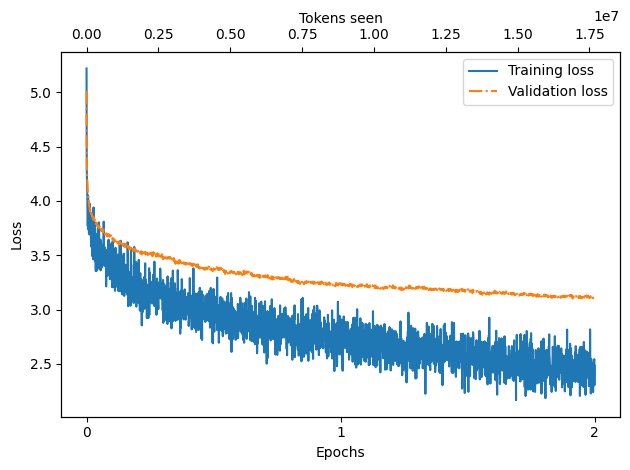

In [ ]:
from pathlib import Path
Path.mkdir(Path('losses/'), exist_ok=True)

from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses, Path('losses/'))

- As we can see, the loss decreases sharply at the beginning of the first epoch, which means the model starts learning quickly
- We can see that slight overfitting sets in at around 1 training epoch

## 7.7 Extracting and saving responses

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-6.webp?1" width=500px>

- In this section, we save the test set responses for scoring in the next section
- We also save a copy of the model for future use
- But first, let's take a brief look at the responses generated by the finetuned model

In [ ]:
BASE_CONFIG = {
    "vocab_size": 50000,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-key-value bias
}

In [ ]:
%%writefile gpt_model_code2.py


Overwriting gpt_model_code2.py


In [ ]:
torch.manual_seed(123)
from previous_chapters import text_to_token_ids
for entry in test_data[:3]:

    input_text = format_input(entry)

    # token_ids = generate(
    #     model=model,
    #     idx=text_to_token_ids(input_text, tokenizer).to(device),
    #     max_new_tokens=256,
    #     context_size=BASE_CONFIG["context_length"],
    #     eos_id=50256
    # )
    # generated_text = token_ids_to_text(token_ids, tokenizer)
    generated_text = generate(model=model, prompt=input_text, tokenizer=tokenizer,
         max_new_tokens=256, temperature=0.7, top_k=50, top_p=None,  # New parameter for nucleus sampling
         eos_id=None, repetition_penalty=1.2, penalize_len_below=50)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

तल दियीएको निर्देशन को उचित प्रतिक्रिया दिनुहोस।

### प्रतिक्रिया:
दिइएको अनुच्छेदमा शीर्ष 5 सबैभन्दा बारम्बार क्रियाहरूको सूची उत्पन्न गर्नुहोस्।

### इनपुट:
ज्याकेन पार्कको वरिपरि दुई पटक हिँडे र त्यसपछि तालको वरिपरि दौडे। साम उनको पछाडि हिँडे।

Correct response:
>> 1. हिँडे।

2. रेस

3. जोगिङ

4. वरपर

5। पछाडि

Model response:
>> पछाडि हिँडे । उनले तालको छेउमा हिंडिन् र ताल गहिरो छ कि भनेर जाँच गर्न थालिन् ।
-------------------------------------
तल दियीएको निर्देशन को उचित प्रतिक्रिया दिनुहोस।

### प्रतिक्रिया:
दुई वाक्यहरू बिच उपयुक्त संक्रमणहरू प्रदान गर्न अनुच्छेदमा वाक्य घुसाउनुहोस्।

### इनपुट:
डेभले चाँडै आफ्नो मन परिवर्तन गरे। उनले चलचित्र जाने निर्णय गरे।

Correct response:
>> डेभले चाँडै आफ्नो मन परिवर्तन गरे। आफूले योजना गरेझैँ बस्नुको सट्टा, उनले चलचित्रहरूमा जाने निर्णय गरे।

Model response:
>> णय गरे ।
-------------------------------------
तल दियीएको निर्देशन को उचित प्रतिक्रिया दिनुहोस।

### प्रतिक्रिया:
खाली ठाउँ भर्न एउटा शब्द दिनुहोस्

### इनपुट:
समाचार सुनेपछि उनी

- As we can see based on the test set instructions, given responses, and the model's responses, the model performs relatively well
- The answers to the first and last instructions are clearly correct
- The second answer is close; the model answers with "cumulus cloud" instead of "cumulonimbus" (however, note that cumulus clouds can develop into cumulonimbus clouds, which are capable of producing thunderstorms)
- Most importantly, we can see that model evaluation is not as straightforward as in the previous chapter, where we just had to calculate the percentage of correct spam/non-spam class labels to obtain the classification accuracy
- In practice, instruction-finetuned LLMs such as chatbots are evaluated via multiple approaches
  - short-answer and multiple choice benchmarks such as MMLU ("Measuring Massive Multitask Language Understanding", [https://arxiv.org/abs/2009.03300](https://arxiv.org/abs/2009.03300)), which test the knowledge of a model
  - human preference comparison to other LLMs, such as LMSYS chatbot arena ([https://arena.lmsys.org](https://arena.lmsys.org))
  - automated conversational benchmarks, where another LLM like GPT-4 is used to evaluate the responses, such as AlpacaEval ([https://tatsu-lab.github.io/alpaca_eval/](https://tatsu-lab.github.io/alpaca_eval/))

- In the next section, we will use an approach similar to AlpacaEval and use another LLM to evaluate the responses of our model; however, we will use our own test set instead of using a publicly available benchmark dataset
- For this, we add the model response to the `test_data` dictionary and save it as a `"instruction-data-with-response.json"` file for record-keeping so that we can load and analyze it in separate Python sessions if needed

In [ ]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)
    generated_text = generate(model=model, prompt=input_text, tokenizer=tokenizer,
         max_new_tokens=256, temperature=0.7, top_k=50, top_p=None,  # New parameter for nucleus sampling
         eos_id=None, repetition_penalty=1.2, penalize_len_below=50)
    # token_ids = generate(
    #     model=model,
    #     idx=text_to_token_ids(input_text, tokenizer).to(device),
    #     max_new_tokens=256,
    #     context_size=BASE_CONFIG["context_length"],
    #     eos_id=50256
    # )
    # generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

 13%|█▎        | 804/6348 [01:25<09:50,  9.38it/s]


RuntimeError: The expanded size of the tensor (974) must match the existing size (512) at non-singleton dimension 3.  Target sizes: [1, 12, 974, 974].  Tensor sizes: [512, 512]

- Let's double-check one of the entries to see whether the responses have been added to the `test_data` dictionary correctly

In [ ]:
print(test_data[0])

In [ ]:
print('.')

- Finally, we also save the model in case we want to reuse it in the future

In [ ]:
import re

CHOOSE_MODEL = "gpt2-fine_tuned"
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-fine_tuned-sft.pth


## 7.8 Evaluating the finetuned LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-7.webp?1" width=500px>

- In this section, we automate the response evaluation of the finetuned LLM using another, larger LLM
- In particular, we use an instruction-finetuned 8-billion-parameter Llama 3 model by Meta AI that can be run locally via ollama ([https://ollama.com](https://ollama.com))
- (Alternatively, if you prefer using a more capable LLM like GPT-4 via the OpenAI API, please see the [llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb) notebook)

- Ollama is an application to run LLMs efficiently
- It is a wrapper around llama.cpp ([https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp)), which implements LLMs in pure C/C++ to maximize efficiency
- Note that it is a tool for using LLMs to generate text (inference), not training or finetuning LLMs
- Before running the code below, install ollama by visiting [https://ollama.com](https://ollama.com) and following the instructions (for instance, clicking on the "Download" button and downloading the ollama application for your operating system)

- For macOS and Windows users, click on the ollama application you downloaded; if it prompts you to install the command line usage, say "yes"
- Linux users can use the installation command provided on the ollama website

- In general, before we can use ollama from the command line, we have to either start the ollama application or run `ollama serve` in a separate terminal

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ollama-run.webp?1" width=700px>


- With the ollama application or `ollama serve` running in a different terminal, on the command line, execute the following command to try out the 8-billion-parameter Llama 3 model (the model, which takes up 4.7 GB of storage space, will be automatically downloaded the first time you execute this command)

```bash
# 8B model
ollama run llama3
```


The output looks like as follows

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```

- Note that `llama3` refers to the instruction finetuned 8-billion-parameter Llama 3 model

- Using ollama with the `"llama3"` model (a 8B parameter model) requires 16 GB of RAM; if this is not supported by your machine, you can try the smaller model, such as the 3.8B parameter phi-3 model by setting `model = "phi-3"`, which only requires 8 GB of RAM

- Alternatively, you can also use the larger 70-billion-parameter Llama 3 model, if your machine supports it, by replacing `llama3` with `llama3:70b`

- After the download has been completed, you will see a command line prompt that allows you to chat with the model

- Try a prompt like "What do llamas eat?", which should return an output similar to the following

```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
```

- You can end this session using the input `/bye`

- The following code checks whether the ollama session is running correctly before proceeding to use ollama to evaluate the test set responses we generated in the previous section

In [ ]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

In [ ]:
# This cell is optional; it allows you to restart the notebook
# and only run section 7.7 without rerunning any of the previous code
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- Now, an alternative way to the `ollama run` command we used earlier to interact with the model is via its REST API in Python via the following function
- Before you run the next cells in this notebook, make sure that ollama is still running (the previous code cells should print `"Ollama running: True"`)
- Next, run the following code cell to query the model

In [ ]:
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

- Now, using the `query_model` function we defined above, we can evaluate the responses of our finetuned model; let's try it out on the first 3 test set responses we looked at in a previous section

In [ ]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")

- As we can see, the Llama 3 model provides a reasonable evaluation and also gives partial points if a model is not entirely correct, as we can see based on the "cumulus cloud" answer
- Note that the previous prompt returns very verbose evaluations; we can tweak the prompt to generate integer responses in the range between 0 and 100 (where 100 is best) to calculate an average score for our model
- The evaluation of the 110 entries in the test set takes about 1 minute on an M3 MacBook Air laptop

In [ ]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

- Our model achieves an average score of above 50, which we can use as a reference point to compare the model to other models or to try out other training settings that may improve the model
- Note that ollama is not fully deterministic across operating systems (as of this writing), so the numbers you are getting might slightly differ from the ones shown above

- For reference, the original
  - Llama 3 8B base model achieves a score of 58.51
  - Llama 3 8B instruct model achieves a score of 82.65

## 7.9 Conclusions

### 7.9.1 What's next

- This marks the final chapter of this book
- We covered the major steps of the LLM development cycle: implementing an LLM architecture, pretraining an LLM, and finetuning it

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/final-overview.webp?1" width=500px>

- An optional step that is sometimes followed after instruction finetuning, as described in this chapter, is preference finetuning
- Preference finetuning process can be particularly useful for customizing a model to better align with specific user preferences; see the [../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo) folder if you are interested in this

- This GitHub repository also contains a large selection of additional bonus material you may enjoy; for more information, please see the [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) section on this repository's README page

### 7.9.2 Staying up to date in a fast-moving field

- No code in this section

### 7.9.3 Final words

- I hope you enjoyed this journey of implementing an LLM from the ground up and coding the pretraining and finetuning functions
- In my opinion, implementing an LLM from scratch is the best way to understand how LLMs work; I hope you gained a better understanding through this approach
- While this book serves educational purposes, you may be interested in using different and more powerful LLMs for real-world applications
  - For this, you may consider popular tools such as axolotl ([https://github.com/OpenAccess-AI-Collective/axolotl](https://github.com/OpenAccess-AI-Collective/axolotl)) or LitGPT ([https://github.com/Lightning-AI/litgpt](https://github.com/Lightning-AI/litgpt)), which I help developing

## Summary and takeaways

- See the [./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py) script, a self-contained script for classification finetuning
- [./ollama_evaluate.py](./ollama_evaluate.py) is a standalone script based on section 7.8 that evaluates a JSON file containing "output" and "response" keys via Ollama and Llama 3
- The [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb) notebook illustrates how to load the finetuned model in a new session
- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)

## What's next?

- Congrats on completing the book; in case you are looking for additional resources, I added several bonus sections to this GitHub repository that you might find interesting
- The complete list of bonus materials can be viewed in the main README's [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) section
- To highlight a few of my favorites:
  1. [Direct Preference Optimization (DPO) for LLM Alignment (From Scratch)](../04_preference-tuning-with-dpo/dpo-from-scratch.ipynb) implements a popular preference tuning mechanism to align the model from this chapter more closely with human preferences
  2. [Llama 3.2 From Scratch (A Standalone Notebook)](../../ch05/07_gpt_to_llama/standalone-llama32.ipynb), a from-scratch implementation of Meta AI's popular Llama 3.2, including loading the official pretrained weights; if you are up to some additional experiments, you can replace the `GPTModel` model in each of the chapters with the `Llama3Model` class (it should work as a 1:1 replacement)
  3. [Converting GPT to Llama](../../ch05/07_gpt_to_llama) contains code with step-by-step guides that explain the differences between GPT-2 and the various Llama models
  4. [Understanding the Difference Between Embedding Layers and Linear Layers](../../ch02/03_bonus_embedding-vs-matmul/embeddings-and-linear-layers.ipynb) is a conceptual explanation illustrating that the `Embedding` layer in PyTorch, which we use at the input stage of an LLM, is mathematically equivalent to a linear layer applied to one-hot encoded data
- Happy further reading!

# Done
- [X] Remove english dataset from wiseyak by (using langid)

# Todo

- [ ] More data
- [ ] more epochs
- [ ] save to hub
- [ ] Assistant fine tuning